In [1]:
import os
import sys
import copy

import matplotlib.pyplot as plt
import numpy as np

import anotherpipe.powerestimation.powerestimate as pe

from pypower import PowerSpectrumSmoothWindowMatrix

sys.path.append('../bin')
from sculpt_window import get_data, SculptWindow
from utils import load_poles
from local_file_manager import LocalFileName
from desi_file_manager import DESIFileName

plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

In [2]:
source = 'desi'
mockgen = 'second'
version = 'v3'

tracer = "ELG_LOPnotqso"
region = "SGC"
zrange = (0.8, 1.1)
completeness = True

ells = [0, 2, 4]

kolim = (0., 0.4)
korebin = 5
ktmax = 0.5
ktrebin = 1

rpcut = 0.
thetacut = 0.05

capsig = 5
difflfac = 10
covtype = 'analytic'

## Input & transformed $P(k)$, $W(k, k^{\prime})$, $C$

In [3]:
data_dir = "/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/{}/sculpt_window".format(version)

sculptwm_fn = LocalFileName().set_default_config(ftype='sculpt_all', tracer=tracer, region=region, completeness=completeness, realization=None, rpcut=rpcut, thetacut=thetacut)
sculptwm_fn.sculpt_attrs['ells'] = ells
sculptwm_fn.sculpt_attrs['kobsmax'] = kolim[-1]
sculptwm_fn.sculpt_attrs['ktmax'] = ktmax
sculptwm_fn.sculpt_attrs['capsig'] = capsig
sculptwm_fn.sculpt_attrs['difflfac'] = difflfac
sculptwm_fn.sculpt_attrs['covtype'] = covtype
sculptwm_fn.update(fdir=data_dir, zrange=zrange, cellsize=None, boxsize=None, directedges=False)
sculptwm = SculptWindow.load(sculptwm_fn.get_path())

wm = sculptwm.wmatrix
pk = sculptwm.pk
cov = sculptwm.cov

wmnew = sculptwm.wmatrixnew
pknew = sculptwm.pknew
mmatrix = sculptwm.mmatrix
mo = sculptwm.mo

In [4]:
data_nocut = get_data(source=source, catalog=mockgen, version=version, tracer=tracer, region=region, rpcut=0, thetacut=0, zrange=zrange, kolim=kolim, korebin=korebin, ktmax=ktmax, ktrebin=ktrebin, covtype=covtype)
wm_nocut = data_nocut['wmatrix']

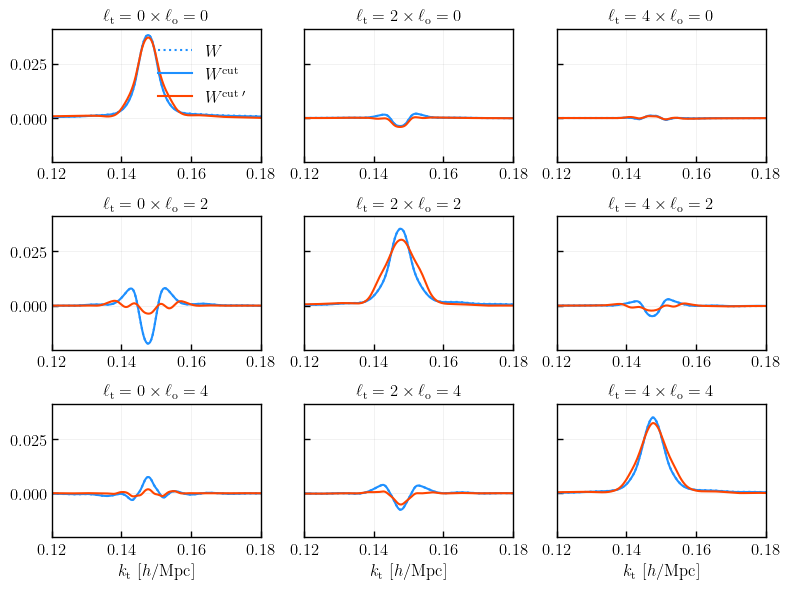

In [5]:
kobs = [0.15]
alphas = [1.]

fig, lax = plt.subplots(len(ells), len(ells), sharey=True, figsize=(8, 6))

for i in range(len(kobs)):
    indexout = np.abs(wm.xout[0] - kobs[i]).argmin()
    
    for iin, projin in enumerate(ells):
        for iout, projout in enumerate(ells):
            ax = lax[iout][iin]
            # Indices in approximative window matrix
            norm = 1. #np.max(np.abs(wm.unpacked()[iin][iout][:, indexout] / wm.xin[iin]))
            ax.plot(wm_nocut.xin[iin], wm_nocut.unpacked()[iin][iout][:, indexout]/norm, label=r'$W$' if i==len(kobs)-1 else '', color='C0', ls=':', alpha=alphas[i])
            ax.plot(wm.xin[iin], wm.unpacked()[iin][iout][:, indexout]/norm, label=r'$W^{\mathrm{cut}}$' if i==len(kobs)-1 else '', color='C0', alpha=alphas[i])
            ax.plot(wmnew.xin[iin], wmnew.unpacked()[iin][iout][:, indexout]/norm, label=r'$W^{\mathrm{cut} \; \prime}$' if i==len(kobs)-1 else '', color='C1', alpha=alphas[i])
            ax.set_title(r'$\ell_{{\mathrm{{t}}}} = {:d} \times \ell_{{\mathrm{{o}}}} = {:d}$'.format(projin, projout))
            ax.set_xlim((0.12, 0.18))
            if iout == len(ells) - 1: ax.set_xlabel(r'$k_{\mathrm{t}}$ [$h/\mathrm{Mpc}$]')
            if i==len(kobs)-1 and iin == iout == 0: lax[iout][iin].legend()

plt.savefig(os.path.join(plots_dir, version, 'sculptedwindow_{}_complete_{}_{}_{}_{}cut{:.2f}_ells{}_capsig{}_difflfac{}_{}cov.pdf'.format(tracer, region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsig, difflfac, covtype)), dpi=300)
plt.show()

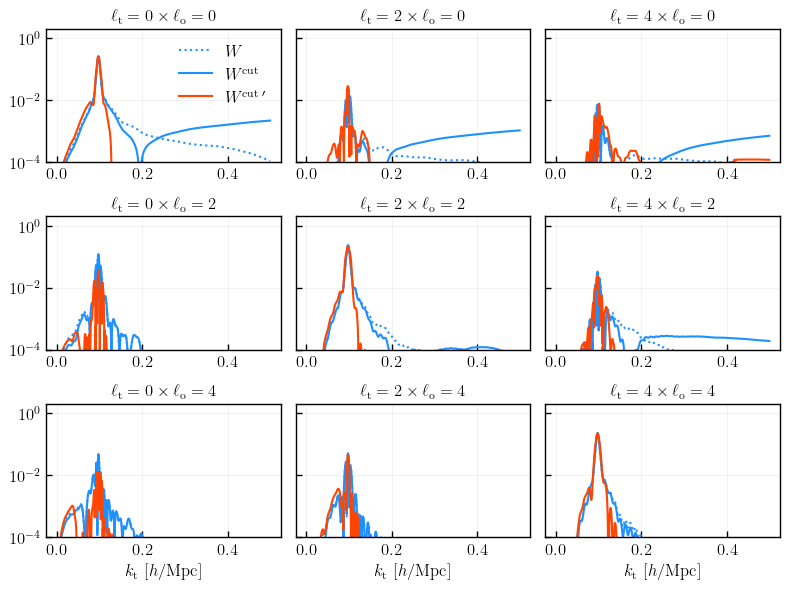

In [6]:
kouts = [0.1]
alphas = np.linspace(1, 0.2, len(kouts))

fig, lax = plt.subplots(len(ells), len(ells), sharey=True, figsize=(8, 6))

for iin, projin in enumerate(ells):
    for iout, projout in enumerate(ells):
        ax = lax[iout][iin]

        for ki, kout in enumerate(kouts):
            indexout = np.abs(wm.xout[0] - kout).argmin()
            # Indices in approximative window matrix
            norm = 1 #np.max(np.abs(wm.unpacked()[iin][iout][:, indexout] / wm.xin[iin]))
            ax.semilogy(wm_nocut.xin[iin], np.abs(wm_nocut.unpacked()[iin][iout][:, indexout]/norm/wm_nocut.xin[iin]), alpha=alphas[ki], color='C0', ls=':', label=r'$W$' if ki==0 else '')
            ax.semilogy(wm.xin[iin], np.abs(wm.unpacked()[iin][iout][:, indexout]/norm/wm.xin[iin]), alpha=alphas[ki], color='C0', label=r'$W^{\mathrm{cut}}$' if ki==0 else '')
            ax.semilogy(wmnew.xin[iin], np.abs(wmnew.unpacked()[iin][iout][:, indexout]/norm/wmnew.xin[iin]), alpha=alphas[ki], color='C1', label=r'$W^{\mathrm{cut} \; \prime}$' if ki==0 else '')
        ax.set_title(r'$\ell_{{\mathrm{{t}}}} = {:d} \times \ell_{{\mathrm{{o}}}} = {:d}$'.format(projin, projout))
        ax.set_ylim((1e-4, 2))
        if iout == len(ells) - 1: ax.set_xlabel(r'$k_{\mathrm{t}}$ [$h/\mathrm{Mpc}$]')
        if iin == iout == 0: lax[iout][iin].legend()

plt.savefig(os.path.join(plots_dir, version, 'sculptedwindow_semilogy_{}_complete_{}_{}_{}_{}cut{:.2f}_ells{}_capsig{}_difflfac{}_{}cov.pdf'.format(tracer, region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsig, difflfac, covtype)), dpi=300)
plt.show()

### Quantify gain in compactness of the window

In [7]:
def compacity(wmatrix, ells=[0, 2, 4], alpha=0.95):
    w = wmatrix.deepcopy()
    if len(ells)==1:
        w.select_proj(projsout=(0, None))
    else:
        w.select_proj(projsout=[(ell, None) for ell in ells])
    # split in multipoles
    wsplit = np.array_split(w.value, 3, axis=0)
    kin = w.xin[0]
    weights_bf = np.sum(np.array([np.cumsum(np.abs(wsplit[i]), axis=0) for i in range(len(ells))]), axis=0)
    weight_bf = np.sum(np.array_split(weights_bf, len(ells), axis=-1), axis=0)
    weights_tot = np.sum(np.array([np.sum(np.abs(wsplit[i]), axis=0) for i in range(len(ells))]), axis=0)
    weight_tot = np.sum(np.array_split(weights_tot, len(ells), axis=-1), axis=0)
    r = weight_bf / weight_tot
    iktmax = np.argmax(r >= alpha, axis=0)
    return kin[iktmax]

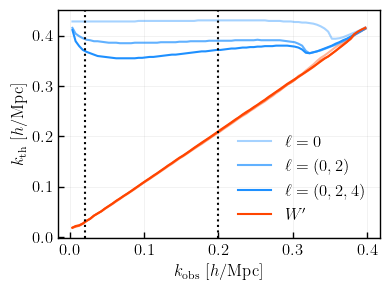

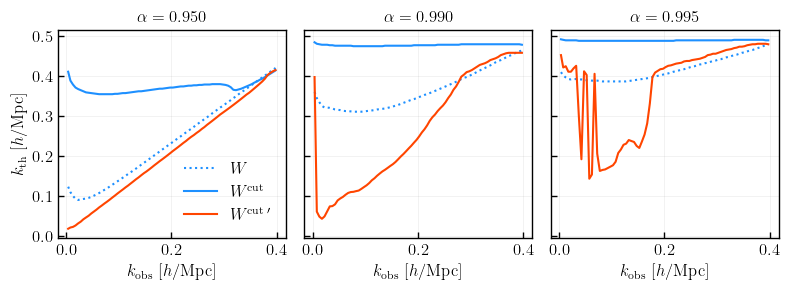

In [8]:
alpha = 0.95
ells = [0, 2, 4]

plt.figure(figsize=(4, 3))
plt.plot(wm.xout[0], compacity(wm, ells=[0], alpha=alpha), color='C0', alpha=0.4, label=r'$\ell = 0$')
plt.plot(wmnew.xout[0], compacity(wmnew, ells=[0], alpha=alpha), color='C1', alpha=0.4)

plt.plot(wm.xout[0], compacity(wm, ells=[0, 2], alpha=alpha), color='C0', alpha=0.7, label=r'$\ell = (0, 2)$')
plt.plot(wmnew.xout[0], compacity(wmnew, ells=[0, 2], alpha=alpha), color='C1', alpha=0.7)

plt.plot(wm.xout[0], compacity(wm, ells=ells, alpha=alpha), label=r'$\ell = (0, 2, 4)$', color='C0')
plt.plot(wmnew.xout[0], compacity(wmnew, ells=ells, alpha=alpha), label=r'$W^{\prime}$', color='C1')

plt.axvline(0.02, ls=':', color='black')
plt.axvline(0.2, ls=':', color='black')

plt.xlabel(r'$k_{\mathrm{obs}}$ [$h$/Mpc]')
plt.ylabel(r'$k_{{\mathrm{{th}}}}$ [$h$/Mpc]'.format(alpha))
plt.legend()
plt.savefig(os.path.join(plots_dir, version, 'compacity_0.95_{}_complete_{}_{}_{}_{}cut{:.2f}_capsig{}_difflfac{}_{}cov.pdf'.format(tracer, region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), capsig, difflfac, covtype)), dpi=100)
plt.show()

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8, 3))

for i, alpha in enumerate([0.95, 0.99, 0.995]):
    axes[i].plot(wm_nocut.xout[0], compacity(wm_nocut, ells=ells, alpha=alpha), color='C0', ls=':')
    axes[i].plot(wm.xout[0], compacity(wm, ells=ells, alpha=alpha), color='C0')
    axes[i].plot(wmnew.xout[0], compacity(wmnew, ells=ells, alpha=alpha), color='C1')
    axes[i].set_xlabel(r'$k_{\mathrm{obs}}$ [$h$/Mpc]')
    axes[i].set_title(r'$\alpha = {:.3f}$'.format(alpha))
axes[0].plot([], [], color='C0', ls=':', label=r'$W$')
axes[0].plot([], [], color='C0', label=r'$W^{\mathrm{cut}}$')
axes[0].plot([], [], color='C1', label=r'$W^{\mathrm{cut} \; \prime}$')
axes[0].set_ylabel(r'$k_{{\mathrm{{th}}}}$ [$h$/Mpc]'.format(alpha))
axes[0].legend()
plt.savefig(os.path.join(plots_dir, version, 'compacity_{}_complete_{}_{}_{}_{}cut{:.2f}_capsig{}_difflfac{}_{}cov.pdf'.format(tracer, region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), capsig, difflfac, covtype)), dpi=100)
plt.show()

### Transformed $P(k)$

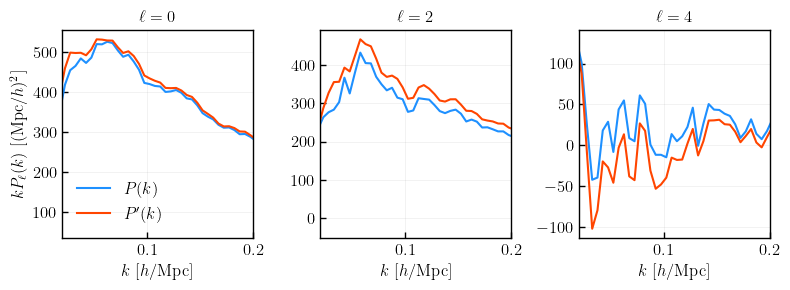

In [9]:
fig, axes = plt.subplots(1, len(ells), figsize=(8, 3), sharey=False)

for i, ell in enumerate(ells):
    axes[i].plot(wm.xout[i], wm.xout[i] * pk(ell=ells, complex=False)[i], color='C0', label=r'$P(k)$')
    axes[i].plot(wmnew.xout[i], wmnew.xout[i] * pknew.reshape((len(ells), len(wmnew.xout[i])))[i], color='C1', label=r'$P^{\prime}(k)$')
    axes[i].set_title(r'$\ell={}$'.format(ell))
    axes[i].set_xlabel(r'$k$  [$h$/Mpc]')
    axes[i].set_xlim((0.02, 0.2))

axes[0].legend()
axes[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.tight_layout(pad=0.3)
plt.savefig(os.path.join(plots_dir, version, 'sculptedwindow_pknew_{}_complete_{}_{}_{}_{}cut{:.2f}_ells{}_capsig{}_difflfac{}_{}cov.pdf'.format(tracer, region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsig, difflfac, covtype)), dpi=300)
plt.show()

### Transformed covariance matrix

In [10]:
covnew = sculptwm.covnew

/tmp/ipykernel_1954147/3153696108.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20231013-1.0.0/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


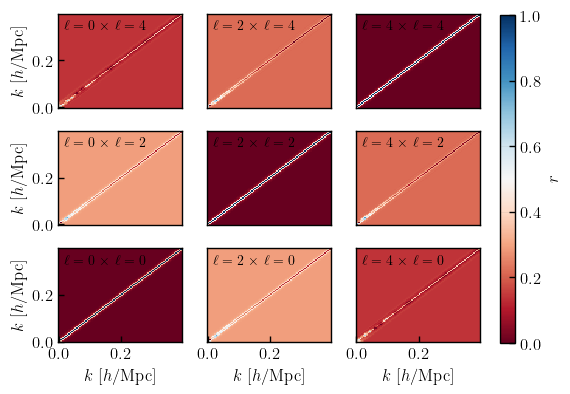

/tmp/ipykernel_1954147/3153696108.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


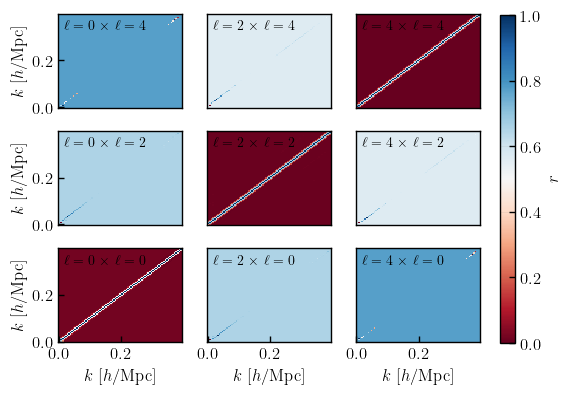

In [11]:
from cov_utils import plot_corrcoef

from matplotlib import colors
norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)

plot_corrcoef(cov, ells, np.arange(kolim[0], kolim[1], 0.005))
plt.tight_layout()
plt.show()

plot_corrcoef(covnew, ells, np.arange(kolim[0], kolim[1], 0.005))
plt.tight_layout()
plt.show()

### EZmocks covariance obtained with M from analytic covariance

In [17]:
cov_ezmocks = get_data(source=source, catalog=mockgen, version=version, tracer=tracer, region=region, rpcut=0, thetacut=0.05, zrange=zrange, kolim=kolim, korebin=korebin, ktmax=ktmax, ktrebin=ktrebin, covtype='ezmocks')['covariance']

1000
523


In [56]:
covnew_ezmocks = np.matmul(np.matmul(mmatrix, cov_ezmocks), mmatrix.T) #- np.sum(np.array([np.array(sculptwm.m)[i] * np.outer(mo[i], mo[i]) for i in range(len(ells))]), axis=0)

/tmp/ipykernel_1954147/319261700.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


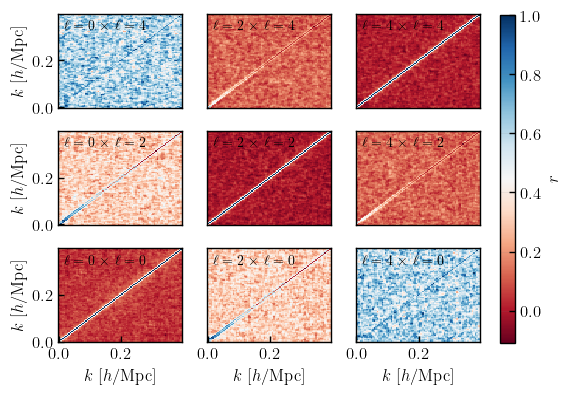

/tmp/ipykernel_1954147/319261700.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


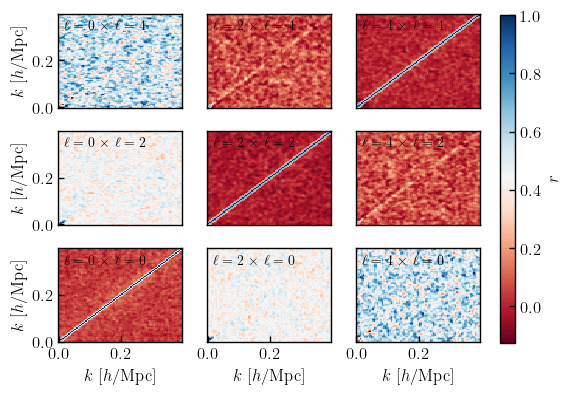

In [57]:
plot_corrcoef(cov_ezmocks, ells, np.arange(kolim[0], kolim[1], 0.005))
plt.tight_layout()
plt.show()

plot_corrcoef(covnew_ezmocks, ells, np.arange(kolim[0], kolim[1], 0.005))
plt.tight_layout()
plt.show()

In [62]:
np.sum(np.array([np.array(sculptwm.m)[i] * np.outer(mo[i], mo[i]) for i in range(len(ells))]), axis=0)/covnew_ezmocks

array([[-6.33794445e-10, -2.08724875e-09, -8.98512183e-09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.08724875e-09, -1.85734636e-09, -4.10792321e-09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.98512183e-09, -4.10792321e-09, -3.10972519e-09, ...,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00, ...,
        -3.02889472e-03, -5.28312439e-03, -1.56632606e-02],
       [ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00, ...,
        -5.28312439e-03, -3.70637120e-03, -5.19053840e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.56632606e-02, -5.19053840e-03, -3.45759718e-03]])